<a href="https://colab.research.google.com/github/zeligism/ConGAN/blob/main/GAN_%2B_SimSiam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Header

## Imports

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import glob
import random
import datetime
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torch.utils.tensorboard as tensorboard

from PIL import Image, ImageDraw
from math import log2
from pprint import pformat
from collections import defaultdict

## Utility Functions

### Report Utils

In [3]:
def plot_lines(losses_dict, filename=None, title=""):
    """
    Plots the losses of the discriminator and the generator.

    Args:
        filename: The plot's filename. If None, plot won't be saved.
    """

    plt.figure(figsize=(10,5))
    plt.title(title)
    for label, losses in losses_dict.items():
        plt.plot(losses, label=label)
    plt.xlabel("t")
    plt.legend()
    
    if filename is not None:
        plt.savefig(filename)
    
    plt.show()
    plt.close()


def create_progress_animation(frames, filename):
    """
    Creates a video of the progress of the generator on a fixed latent vector.

    Args:
        filename: The animation's filename.
    """

    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    ims = [[plt.imshow(img.permute(1,2,0), animated=True)]
           for img in frames]
    ani = animation.ArtistAnimation(fig, ims, blit=True)
    
    ani.save(filename)

    plt.close()


def generate_grid(generator, latent):
    """
    Check generator's output on latent vectors and return it.

    Args:
        generator: The generator.
        latent: Latent vector from which an image grid will be generated.

    Returns:
        A grid of images generated by `generator` from `latent`.
    """

    with torch.no_grad():
        fake = generator(latent).detach()

    image_grid = vutils.make_grid(fake.cpu(), padding=2, normalize=True, range=(-1,1))

    return image_grid



# Classes

## PyTorch Modules

### DCGAN

In [4]:
class ConvBlock(nn.Module):
    """
    Default stride and padding half the size of features,
    e.g. if input is [in_channels, 64, 64], output will be [out_channels, 32, 32].
    """
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1,
                 use_batchnorm=True, use_spectralnorm=False, activation=None):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding, bias=False)
        if use_spectralnorm:
            self.conv = nn.utils.spectral_norm(self.conv)
        self.batchnorm = nn.BatchNorm2d(out_channels) if use_batchnorm else None
        self.activation = nn.LeakyReLU(0.2, inplace=True) if activation is None else activation()

    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm:
            x = self.batchnorm(x)
        x = self.activation(x)
        return x


class ConvTBlock(nn.Module):
    """
    Default stride and padding double the size of features,
    e.g. if input is [in_channels, 32, 32], output will be [out_channels, 64, 64].
    """
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1,
                 use_batchnorm=True, use_spectralnorm=False, activation=None):
        super().__init__()

        self.convT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size,
                                        stride=stride, padding=padding, bias=False)
        if use_spectralnorm:
            self.convT = nn.utils.spectral_norm(self.convT)
        self.batchnorm = nn.BatchNorm2d(out_channels) if use_batchnorm else None
        self.activation = nn.ReLU(inplace=True) if activation is None else activation()

    def forward(self, x):
        x = self.convT(x)
        if self.batchnorm:
            x = self.batchnorm(x)
        x = self.activation(x)
        return x


class DCGAN_Discriminator(nn.Module):
    def __init__(self,
                 num_latents=16,
                 num_features=64,
                 image_channels=3,
                 image_size=64,
                 feature_multiplier=2,
                 max_features=512,
                 gan_type="gan",
                 fully_convolutional=True,
                 activation=None,
                 use_batchnorm=True,
                 use_spectralnorm=False,
                 D_block=ConvBlock):
        super().__init__()

        using_grad_penalty = gan_type in ("gan-gp", "wgan-gp")
        output_sigmoid = gan_type in ("gan", "gan-gp")

        block_config = {
            "activation": activation,
            "use_batchnorm": use_batchnorm and not using_grad_penalty,
            "use_spectralnorm": use_spectralnorm,
        }

        # Calculate intermediate image sizes
        image_sizes = [image_size]
        while image_sizes[-1] > 5:
            image_sizes.append(image_sizes[-1] // 2)
        latent_kernel = image_sizes[-1]  # should be either 3, 4, or 5
        num_layers = len(image_sizes) - 1

        # Calculate feature sizes
        features = [min(max_features, round(num_features * feature_multiplier**i))
                    for i in range(num_layers)]

        # Input layer
        self.input_layer = D_block(image_channels, features[0], **block_config)

        # Intermediate layers
        self.main_layers = nn.Sequential(*[
            D_block(in_features, out_features, **block_config)
            for in_features, out_features in zip(features, features[1:])
        ])

        # Output layer (feature_size = 3, 4, or 5 -> 1)
        if fully_convolutional:
            self.output_layer = nn.Sequential(
                nn.Conv2d(features[-1], num_latents, latent_kernel, bias=False),
                nn.Flatten(),
            )
        else:
            self.output_layer = nn.Sequential(
                nn.Flatten(),
                nn.Linear(features[-1] * latent_kernel**2, num_latents, bias=False)
            )

        # Add sigmoid activation if using regular GAN loss
        self.output_activation = nn.Sigmoid() if output_sigmoid else None

    def forward(self, x):
        x = self.input_layer(x)
        x = self.main_layers(x)
        x = self.output_layer(x)
        if self.output_activation:
            x = self.output_activation(x)
        # Remove H and W dimensions, infer channels dim (remove if 1)
        x = x.view(x.size(0), -1).squeeze(1)
        return x


class DCGAN_Generator(nn.Module):
    def __init__(self,
                 num_latents=100,
                 num_features=64,
                 image_channels=3,
                 image_size=64,
                 feature_multiplier=2,
                 max_features=512,
                 gan_type="gan",
                 fully_convolutional=True,
                 activation=None,
                 use_batchnorm=True,
                 use_spectralnorm=False,
                 G_block=ConvTBlock):
        super().__init__()

        block_config = {
            "activation": activation,
            "use_batchnorm": use_batchnorm,
            "use_spectralnorm": use_spectralnorm
        }

        # Calculate intermediate image sizes
        image_sizes = [image_size]
        while image_sizes[-1] > 5:
            image_sizes.append(image_sizes[-1] // 2)
        latent_kernel = image_sizes[-1]  # should be either 3, 4, or 5
        num_layers = len(image_sizes) - 1

        # Calculate feature sizes
        features = [min(max_features, round(num_features * feature_multiplier**i))
                    for i in range(num_layers)]

        # Reverse order of image sizes and features for generator
        image_sizes = image_sizes[::-1]
        features = features[::-1]

        # Input layer
        if fully_convolutional:
            self.input_layer = G_block(num_latents, features[0], kernel_size=latent_kernel,
                                       stride=1, padding=0, **block_config)
        else:
            self.input_layer = nn.Sequential(
                nn.Flatten(),
                nn.Linear(num_latents, features[0] * image_sizes[0]**2, bias=False),
                View(features[0], image_sizes[0], image_sizes[0])
            )

        # Intermediate layers
        self.main_layers = nn.Sequential(*[
            G_block(in_features, out_features, kernel_size=4+(expected_size%2), **block_config)
            for in_features, out_features, expected_size in zip(features, features[1:], image_sizes[1:])
        ])

        # Output layer
        self.output_layer = nn.ConvTranspose2d(features[-1], image_channels, kernel_size=4+(image_size%2),
                                               stride=2, padding=1, bias=False)
        self.output_activation = nn.Tanh()

    def forward(self, x):
        # Add H and W dimensions, infer channels dim (add if none)
        x = x.view(x.size(0), -1, 1, 1)
        x = self.input_layer(x)
        x = self.main_layers(x)
        x = self.output_layer(x)
        x = self.output_activation(x)
        return x


class DCGAN(nn.Module):
    """Deep Convolutional Generative Adversarial Network"""

    def __init__(self,
                 num_latents=100,
                 num_features=64,
                 image_channels=3,
                 image_size=64,
                 feature_multiplier=2,
                 gan_type="gan",
                 fully_convolutional=True,
                 activation=None,
                 use_batchnorm=True,
                 use_spectralnorm=False,):
        """
        Initializes DCGAN.

        Args:
            num_latents: Number of latent factors.
            num_features: Number of features in the convolutions.
            image_channels: Number of channels in the input image.
            image_size: Size (i.e. height or width) of image.
            gan_type: Type of GAN (e.g. "gan" or "wgan-gp").
        """
        super().__init__()

        self.num_latents = num_latents
        self.num_features = num_features
        self.image_channels = image_channels
        self.image_size = image_size
        self.feature_multiplier = feature_multiplier
        self.gan_type = gan_type
        self.fully_convolutional = fully_convolutional
        self.activation = activation
        self.use_batchnorm = use_batchnorm
        self.use_spectralnorm = use_spectralnorm

        D_params = {
            "num_latents": 1,  # XXX
            "num_features": num_features,
            "image_channels": image_channels,
            "image_size": image_size,
            "feature_multiplier": feature_multiplier,
            "gan_type": gan_type,
            "fully_convolutional": fully_convolutional,
            "activation": activation,
            "use_batchnorm": use_batchnorm,
            "use_spectralnorm": use_spectralnorm,
        }
        G_params = {
            "num_latents": num_latents,
            "num_features": num_features,
            "image_channels": image_channels,
            "image_size": image_size,
            "feature_multiplier": feature_multiplier,
            "gan_type": gan_type,
            "fully_convolutional": fully_convolutional,
            "activation": activation,
            "use_batchnorm": use_batchnorm,
            "use_spectralnorm": use_spectralnorm,
        }

        self.D = DCGAN_Discriminator(**D_params)
        self.G = DCGAN_Generator(**G_params)


class View(nn.Module):
    def __init__(self, *shape, including_batch=False):
        super().__init__()
        self.shape = shape
        self.including_batch = including_batch
    
    def forward(self, x):
        if self.including_batch:
            return x.view(*self.shape)
        else:
            return x.view(x.size(0), *self.shape)


### Residual

In [5]:
class ChannelNoise(nn.Module):
    """
    Channel noise injection module.
    Adds a linearly transformed noise to a convolution layer.
    """

    def __init__(self, num_channels, std=0.02):
        super().__init__()
        self.std = std
        self.scale = nn.Parameter(torch.ones(1, num_channels, 1, 1))


    def forward(self, x):
        noise_size = [x.size()[0], 1, *x.size()[2:]]  # single channel
        noise = self.std * torch.randn(noise_size).to(x)

        return x + self.scale * noise


class ResidualBlock(nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels,
                 dilation=(1,1),
                 downsample=None,
                 dropout_p=0.0):
        super().__init__()

        self.dilation = dilation
        self.downsample = downsample

        self.main = nn.Sequential(
            ### Conv 3x3 ###
            nn.Conv2d(in_channels, out_channels, 3,
                      padding=dilation[0], dilation=dilation[0], bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            ChannelNoise(out_channels),
            ### Conv 3x3 ###
            nn.Conv2d(out_channels, out_channels, 3,
                      padding=dilation[1], dilation=dilation[1], bias=False),
            nn.BatchNorm2d(out_channels),
        )


    def forward(self, x):

        residual = x if self.downsample is None else self.downsample(x)

        return F.relu(self.main(x) + residual)


class ResidualBottleneck(nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels,
                 downsample=None,
                 dilation=1,
                 dropout_p=0.0):
        super().__init__()

        self.downsample = downsample
        self.dilation = dilation

        self.main = nn.Sequential(

            ### Conv 1x1 ###
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),

            ### Conv 3x3 ###
            nn.Conv2d(out_channels, out_channels, 3,
                      padding=dilation[1], dilation=dilation[1], bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),

            ### Conv 1x1 ###
            nn.Conv2d(out_channels, out_channels * 4, 1, bias=False),
            nn.BatchNorm2d(out_channels * 4),
        )


    def forward(self, x):

        residual = x if self.downsample is None else self.downsample(x)

        return F.relu(self.main(x) + residual)



### MaskGAN

In [6]:
class MaskGAN(nn.Module):
    def __init__(self,
                 num_features=64,
                 max_features=512,
                 image_channels=3,
                 image_size=64,
                 feature_multiplier=2,
                 gan_type="gan",
                 with_reference=False):
        super().__init__()

        D_params = {
            "num_features": num_features,
            "max_features": max_features,
            "image_channels": image_channels,
            "image_size": image_size,
            "feature_multiplier": feature_multiplier,
            "gan_type": gan_type,
        }
        G_params = {
            "num_features": num_features,
            "with_reference": with_reference,
        }

        self.D = DCGAN_Discriminator(**D_params)
        self.G = MaskGenerator(**G_params)


class MaskGenerator(nn.Module):
    """A neural network that generates a mask to apply."""
    def __init__(self, num_features=64, with_reference=False):
        super().__init__()

        self.num_features = num_features
        self.with_reference = with_reference

        def make_features_extractor(num_features):
            return nn.Sequential(
                nn.Conv2d(3, num_features, 7, padding=3, bias=False),
                nn.ReLU(),
            )

        # Extract features from source
        self.source_features_extractor = make_features_extractor(self.num_features)

        # Extract features from reference
        if self.with_reference:
            self.reference_features_extractor = make_features_extractor(self.num_features)


        # Double the number of features in the mask generator if with reference
        if self.with_reference:
            num_features *= 2

        self.mask_generator = nn.Sequential(
            ResidualBlock(num_features, num_features),
            ResidualBlock(num_features, num_features, dilation=(2,2)),
            ResidualBlock(num_features, num_features, dilation=(4,4)),
            ResidualBlock(num_features, num_features, dilation=(8,8)),
            nn.Conv2d(num_features, num_features, 3, padding=2, dilation=2, bias=False),
            nn.ReLU(),
            nn.Conv2d(num_features, 3, 3, padding=1, bias=False),
            nn.Tanh(),
        )


    def forward(self, source, reference=None):

        assert reference is None or self.with_reference

        features = self.source_features_extractor(source)

        if self.with_reference:
            reference_features = self.reference_features_extractor(reference)
            features = torch.cat([features, reference_features], dim=1)

        mask = self.mask_generator(features)

        return (source + mask).clamp(-1,1) # XXX: range could go outside [-1, 1] !!!



### SimSiam

In [7]:
class SimSiam(nn.Module):
    """
    Build a SimSiam model.
    """
    def __init__(self, base_encoder, dim=2048, pred_dim=512):
        """
        dim: feature dimension (default: 2048)
        pred_dim: hidden dimension of the predictor (default: 512)
        """
        super(SimSiam, self).__init__()

        # create the encoder
        # num_classes is the output fc dimension, zero-initialize last BNs
        self.encoder = base_encoder(num_classes=dim, zero_init_residual=True)

        # build a 3-layer projector
        prev_dim = self.encoder.fc.weight.shape[1]
        self.encoder.fc = nn.Sequential(nn.Linear(prev_dim, prev_dim, bias=False),
                                        nn.BatchNorm1d(prev_dim),
                                        nn.ReLU(inplace=True), # first layer
                                        nn.Linear(prev_dim, prev_dim, bias=False),
                                        nn.BatchNorm1d(prev_dim),
                                        nn.ReLU(inplace=True), # second layer
                                        self.encoder.fc,
                                        nn.BatchNorm1d(dim, affine=False)) # output layer
        self.encoder.fc[6].bias.requires_grad = False # hack: not use bias as it is followed by BN

        # build a 2-layer predictor
        self.predictor = nn.Sequential(nn.Linear(dim, pred_dim, bias=False),
                                        nn.BatchNorm1d(pred_dim),
                                        nn.ReLU(inplace=True), # hidden layer
                                        nn.Linear(pred_dim, dim)) # output layer

    def forward(self, x1, x2):
        """
        Input:
            x1: first views of images
            x2: second views of images
        Output:
            p1, p2, z1, z2: predictors and targets of the network
            See Sec. 3 of https://arxiv.org/abs/2011.10566 for detailed notations
        """

        # compute features for one view
        z1 = self.encoder(x1) # NxC
        z2 = self.encoder(x2) # NxC

        p1 = self.predictor(z1) # NxC
        p2 = self.predictor(z2) # NxC

        return p1, p2, z1.detach(), z2.detach()

### ConsistentGAN

In [11]:
class ConsistentGAN(nn.Module):
    def __init__(self,
                 base_encoder,
                 repr_dim,
                 pred_dim,
                 latent_dim,
                 *args, **kwargs):
        """
        s ~ S is representation/encoding space, e.g. s = Enc(x).
        z ~ Z is latent/seed space for G, e.g. x_fake ~ G(z).

        Case A:
            - Sample x_real ~ X
            - s <- Encoder(x_real)
            - Sample z ~ Z (coupled with s somehow? e.g. z = f(s) + noise)
            - x_fake <- G(z)
            - Test D on x_real, x_fake, i.e. test whether x in X}
            - Calculate GAN loss
            - Calculate SimSiam loss with Predictor(s)

        Case B: 
            - Sample x_real ~ X
            - s_real <- Encoder(x_real)
            - x_recon <- Decoder(s_real)
            - Sample z ~ Z (e.g. N(0,1) or U(-1,1))
            - s_fake <- G(z)
            - Test D on s_real, s_fake, i.e. test whether Dec(s) in X (how?)
            - Calculate GAN loss
            - Calculate Contrastive/SimSiam loss with Predictor(s)
            - Calculate reconsruction loss, e.g. || Enc(x_recon) - Enc(x_real) ||

        We choose Case B for now.

        Adversarial learning:
            Case A:
                Train D and G so that we can disciminate x based on its representation.
                Train G so that representation has enough info for reconstructing x.
                Ideally, G would generate different views of x given similar s's.
            Case B:
                Train D and G so that we can disciminate representations.
                Train G so that it produces representations as real (close to Enc(x)) as possible.
                This assumes that Enc(x) is the real representation.
                (There is no such thing as any random transformation can be real enough, but
                we should try to mitigate this problem nonetheless. For example, we can at least
                make it stable enough by pre-training Enc/Dec.)
                Ideally, G would produce accurate representations that can be decoded later.

        Contrastive learning:
            If x1 and x2 are views of same x (e.g. x1, x2 = rand_aug(x), rand_aug(x))
            Then, Encoder(x1) should be similar to Encoder(x2), so we do this (SimSiam algorithm):
            min 0.5*{ sim(Predictor(s1), s2.detach()) + sim(Predictor(s2), s1.detach()) }
            where sim = CosineSimilarity(dim=1).
        
        Reconstruction learning:
            We can add a (deterministic) Decoder that learns to decode s to x.
            This does not take into account the invariance of representation to augmentations.
            It simply learns the inverse of Encoder. G will learn to produce represenations
            that are as real as possible, where the Decoder will learn to decode them into their
            corresponding x's such that Enc(Dec(s)) = s (do we stop grad at s for this loss?)

        Architecture:
            We assume x comes from an image dataset, e.g. CIFAR10.
            Encoder-Decoder pair can have a DCGAN-style architecture.
            The generator can also have an arch similar to the decoder.
            Other networks can be simple FCNs.
        """
        super().__init__()
        self.repr_dim = repr_dim
        self.latent_dim = latent_dim
        self.pred_dim = pred_dim

        ### Copied from SimSiam repo >>>>>>>>
        # create the encoder
        # num_classes is the output fc dimension, zero-initialize last BNs
        self.encoder = base_encoder(num_classes=repr_dim, zero_init_residual=True)

        # build a 3-layer projector
        prev_dim = self.encoder.fc.weight.shape[1]
        self.encoder.fc = nn.Sequential(nn.Linear(prev_dim, prev_dim, bias=False),
                                        nn.BatchNorm1d(prev_dim),
                                        nn.ReLU(inplace=True), # first layer
                                        nn.Linear(prev_dim, prev_dim, bias=False),
                                        nn.BatchNorm1d(prev_dim),
                                        nn.ReLU(inplace=True), # second layer
                                        self.encoder.fc,
                                        nn.BatchNorm1d(repr_dim, affine=False)) # output layer
        self.encoder.fc[6].bias.requires_grad = False # hack: not use bias as it is followed by BN

        # build a 2-layer predictor
        self.predictor = nn.Sequential(nn.Linear(repr_dim, pred_dim, bias=False),
                                        nn.BatchNorm1d(pred_dim),
                                        nn.ReLU(inplace=True), # hidden layer
                                        nn.Linear(pred_dim, repr_dim)) # output layer
        ### <<<<<<<<
        
        # Make D's architecture kinda similar to predictor @TODO
        # @XXX: Shouldn't use batchnorm with grad_penalty
        D_hidden_dim = repr_dim // 2
        self.D = nn.Sequential(nn.Linear(repr_dim, D_hidden_dim, bias=False),
                               nn.BatchNorm1d(D_hidden_dim),
                               nn.LeakyReLU(0.2, inplace=True),
                               nn.Linear(D_hidden_dim, D_hidden_dim, bias=False),
                               nn.BatchNorm1d(D_hidden_dim),
                               nn.LeakyReLU(0.2, inplace=True),
                               nn.Linear(D_hidden_dim, D_hidden_dim, bias=False),
                               nn.BatchNorm1d(D_hidden_dim),
                               nn.LeakyReLU(0.2, inplace=True),
                               nn.Linear(D_hidden_dim, 1),
                               nn.Sigmoid())

        # Same for generator (latent -> representations)
        self.G = nn.Sequential(nn.Linear(latent_dim, repr_dim, bias=False),
                               nn.BatchNorm1d(repr_dim),
                               nn.ReLU(inplace=True), # hidden layer
                               nn.Linear(repr_dim, repr_dim, bias=False),
                               nn.BatchNorm1d(repr_dim),
                               nn.ReLU(inplace=True), # hidden layer
                               nn.Linear(repr_dim, repr_dim, bias=False),
                               nn.BatchNorm1d(repr_dim),
                               nn.ReLU(inplace=True), # hidden layer
                               nn.Linear(repr_dim, repr_dim))

        # Decoder should be a ConvT net. We'll use DCGAN's G for now @XXX
        self.decoder = DCGAN_Generator(num_latents=repr_dim, image_size=224)

        # To check progress of G
        self.fixed_latent = self.sample_latent(8*8)
    

    def sample_latent(self, batch_size):

        latent_size = [batch_size, self.latent_dim]
        latent = torch.randn(latent_size)

        return latent

    def forward(self, x1, x2):
        """
        Input:
            x1: first views of images
            x2: second views of images
        Output:
            p1, p2, z1, z2: predictors and targets of the network
            See Sec. 3 of https://arxiv.org/abs/2011.10566 for detailed notations
        """

        # compute features for one view
        z1 = self.encoder(x1) # NxC
        z2 = self.encoder(x2) # NxC

        p1 = self.predictor(z1) # NxC
        p2 = self.predictor(z2) # NxC

        return p1, p2, z1.detach(), z2.detach()


class ConsistentGAN2(nn.Module):
    def __init__(self, repr_dim, latent_dim, *args, **kwargs):
        super().__init__()
        self.repr_dim = repr_dim
        self.latent_dim = latent_dim
        
        # Make D's architecture kinda similar to predictor @TODO
        # @XXX: Shouldn't use batchnorm with grad_penalty
        D_hidden_dim = repr_dim // 4
        self.D = nn.Sequential(nn.Linear(repr_dim, D_hidden_dim, bias=False),
                               nn.LeakyReLU(0.2, inplace=True),
                               nn.Linear(D_hidden_dim, D_hidden_dim, bias=False),
                               nn.BatchNorm1d(D_hidden_dim),
                               nn.LeakyReLU(0.2, inplace=True),
                               nn.Linear(D_hidden_dim, 1),
                               nn.Sigmoid())

        # Same for generator (latent -> representations)
        G_hidden_dim = repr_dim // 4
        self.G = nn.Sequential(nn.Linear(latent_dim, G_hidden_dim, bias=False),
                               nn.BatchNorm1d(G_hidden_dim),
                               nn.ReLU(inplace=True), # hidden layer
                               nn.Linear(G_hidden_dim, G_hidden_dim, bias=False),
                               nn.BatchNorm1d(G_hidden_dim),
                               nn.ReLU(inplace=True), # hidden layer
                               nn.Linear(G_hidden_dim, repr_dim))

        # Decoder should be a ConvT net. We'll use DCGAN's G for now @XXX
        self.decoder = DCGAN_Generator(num_latents=repr_dim, image_size=224)

        # To check progress of G
        self.fixed_latent = self.sample_latent(8*8)
    

    def sample_latent(self, batch_size):

        latent_size = [batch_size, self.latent_dim]
        latent = torch.randn(latent_size)

        return latent


# Training

## Utils

In [11]:
def get_D_loss(gan_type="gan"):
    if gan_type in ("gan", "gan-gp"):
        return D_loss_GAN
    elif gan_type in ("wgan", "wgan-gp"):
        return D_loss_WGAN
    else:
        raise ValueError(f"gan_type {gan_type} not supported")


def get_G_loss(gan_type="gan"):
    if gan_type in ("gan", "gan-gp"):
        return G_loss_GAN
    elif gan_type in ("wgan", "wgan-gp"):
        return G_loss_WGAN
    else:
        raise ValueError(f"gan_type {gan_type} not supported")


def D_loss_GAN(D_real, D_fake, label_smoothing=True):
    
    # Create (noisy) real and fake labels XXX
    if label_smoothing:
        real_label = 0.7 + 0.5 * torch.rand_like(D_real)
    else:
        real_label = torch.ones_like(D_real) - 0.1
    fake_label = torch.zeros_like(D_fake)

    # Calculate binary cross entropy loss
    D_loss_real = F.binary_cross_entropy(D_real, real_label)
    D_loss_fake = F.binary_cross_entropy(D_fake, fake_label)

    # Loss is: - log(D(x)) - log(1 - D(x_g)),
    # which is equiv. to maximizing: log(D(x)) + log(1 - D(x_g))
    D_loss = D_loss_real + D_loss_fake

    return D_loss.mean()


def D_loss_WGAN(D_real, D_fake):

    # Maximize: D(x) - D(x_g) - const * (|| grad of D(x_i) wrt x_i || - 1)^2,
    # where x_i <- eps * x + (1 - eps) * x_g, and eps ~ rand(0,1)
    D_loss = -1 * (D_real - D_fake)

    return D_loss.mean()


def G_loss_GAN(D_fake):

    # Calculate binary cross entropy loss with a fake binary label
    fake_label = torch.zeros_like(D_fake)

    # Loss is: -log(D(G(z))), which is equiv. to minimizing log(1-D(G(z)))
    # We use this loss vs. the original one for stability only.
    G_loss = F.binary_cross_entropy(D_fake, 1 - fake_label)

    return G_loss.mean()


def G_loss_WGAN(D_fake):

    # Minimize: -D(G(z))
    G_loss = -D_fake
    
    return G_loss.mean()


def interpolate(real, fake):
    eps = torch.rand(real.size(0), 1, 1, 1).to(real)
    return eps * real + (1 - eps) * fake

def simple_gradient_penalty(D, x, center=0.):
    x.requires_grad_()
    D_x = D(x)
    D_grad = torch.autograd.grad(D_x, x, torch.ones_like(D_x), create_graph=True)
    D_grad_norm = D_grad[0].view(x.size(0), -1).norm(dim=1)
    return (D_grad_norm - center).pow(2).mean()


In [12]:
from PIL import ImageFilter
import random


class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]


class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x

## Main

In [13]:
# Copied from SimSiam repo with some adjustments >>>>>>>>
import argparse
import builtins
import math
import os
import random
import shutil
import time
import warnings

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

RESULTS_DIR = "/content/drive/My Drive/gansiam/results/"
GENERATED_GRIDS = []

def main(args):

    if args.seed is not None:
        random.seed(args.seed)
        torch.manual_seed(args.seed)
        cudnn.deterministic = True
        warnings.warn('You have chosen to seed training. '
                      'This will turn on the CUDNN deterministic setting, '
                      'which can slow down your training considerably! '
                      'You may see unexpected behavior when restarting '
                      'from checkpoints.')

    if args.gpu is not None:
        warnings.warn('You have chosen a specific GPU. This will completely '
                      'disable data parallelism.')

    if args.dist_url == "env://" and args.world_size == -1:
        args.world_size = int(os.environ["WORLD_SIZE"])

    args.distributed = args.world_size > 1 or args.multiprocessing_distributed

    ngpus_per_node = torch.cuda.device_count()
    if args.multiprocessing_distributed:
        # Since we have ngpus_per_node processes per node, the total world_size
        # needs to be adjusted accordingly
        args.world_size = ngpus_per_node * args.world_size
        # Use torch.multiprocessing.spawn to launch distributed processes: the
        # main_worker process function
        mp.spawn(main_worker, nprocs=ngpus_per_node, args=(ngpus_per_node, args))
    else:
        # Simply call main_worker function
        main_worker(args.gpu, ngpus_per_node, args)


def main_worker(gpu, ngpus_per_node, args):
    args.gpu = gpu

    # suppress printing if not master
    if args.multiprocessing_distributed and args.gpu != 0:
        def print_pass(*args):
            pass
        builtins.print = print_pass

    if args.gpu is not None:
        print("Use GPU: {} for training".format(args.gpu))

    if args.distributed:
        if args.dist_url == "env://" and args.rank == -1:
            args.rank = int(os.environ["RANK"])
        if args.multiprocessing_distributed:
            # For multiprocessing distributed training, rank needs to be the
            # global rank among all the processes
            args.rank = args.rank * ngpus_per_node + gpu
        dist.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                world_size=args.world_size, rank=args.rank)
        torch.distributed.barrier()
    # create model
    print("=> creating model '{}'".format(args.arch))
    # <<<<<<<<<<
    model = ConsistentGAN(models.__dict__[args.arch],
                          args.dim,
                          args.pred_dim,
                          args.latent_dim)
    # >>>>>>>>>>

    # infer learning rate before changing batch size
    init_lr = args.lr * args.batch_size / 256

    if args.distributed:
        # Apply SyncBN
        model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(model)
        # For multiprocessing distributed, DistributedDataParallel constructor
        # should always set the single device scope, otherwise,
        # DistributedDataParallel will use all available devices.
        if args.gpu is not None:
            torch.cuda.set_device(args.gpu)
            model.cuda(args.gpu)
            # When using a single GPU per process and per
            # DistributedDataParallel, we need to divide the batch size
            # ourselves based on the total number of GPUs we have
            args.batch_size = int(args.batch_size / ngpus_per_node)
            args.workers = int((args.workers + ngpus_per_node - 1) / ngpus_per_node)
            model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.gpu])
        else:
            model.cuda()
            # DistributedDataParallel will divide and allocate batch_size to all
            # available GPUs if device_ids are not set
            model = torch.nn.parallel.DistributedDataParallel(model)
    elif args.gpu is not None:
        torch.cuda.set_device(args.gpu)
        model = model.cuda(args.gpu)
        # comment out the following line for debugging
        #raise NotImplementedError("Only DistributedDataParallel is supported.")
    else:
        # AllGather implementation (batch shuffle, queue update, etc.) in
        # this code only supports DistributedDataParallel.
        raise NotImplementedError("Only DistributedDataParallel is supported.")
    print(model) # print model after SyncBatchNorm

    # define loss function (criterion) and optimizer
    criterion = nn.CosineSimilarity(dim=1).cuda(args.gpu)
    # <<<<<<<<<<
    # Define D and G loss functions
    if args.gan_type == "wgan":
        D_criterion = D_loss_WGAN
        G_criterion = G_loss_WGAN
    else:
        D_criterion = D_loss_GAN
        G_criterion = G_loss_GAN
    # >>>>>>>>>>

    if args.fix_pred_lr:
        optim_params = [{'params': model.encoder.parameters(), 'fix_lr': False},
                        {'params': model.predictor.parameters(), 'fix_lr': True}]
    else:
        optim_params = model.parameters()

    optimizer = torch.optim.SGD(optim_params, init_lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)
    # <<<<<<<<<<
    D_optimizer = torch.optim.SGD(model.D.parameters(), init_lr/5,
                                  momentum=args.momentum,
                                  )#weight_decay=args.weight_decay)
    G_optimizer = torch.optim.SGD(model.G.parameters(), init_lr/10,
                                  momentum=args.momentum,
                                  )#weight_decay=args.weight_decay)
    decoder_optimizer = torch.optim.SGD(model.decoder.parameters(), init_lr/5,
                                  momentum=args.momentum,
                                  weight_decay=args.weight_decay)
    # >>>>>>>>>>

    # optionally resume from a checkpoint
    if args.resume:
        if os.path.isfile(args.resume):
            print("=> loading checkpoint '{}'".format(args.resume))
            if args.gpu is None:
                checkpoint = torch.load(args.resume)
            else:
                # Map model to be loaded to specified single gpu.
                loc = 'cuda:{}'.format(args.gpu)
                checkpoint = torch.load(args.resume, map_location=loc)
            args.start_epoch = checkpoint['epoch']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(args.resume))

    cudnn.benchmark = True

    # Data loading code
    traindir = os.path.join(args.data, 'train')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    # MoCo v2's aug: similar to SimCLR https://arxiv.org/abs/2002.05709
    augmentation = [
        transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]

    # <<<<<<<<<<
    """
    train_dataset = datasets.ImageFolder(
        traindir,
        TwoCropsTransform(transforms.Compose(augmentation)))
    """
    train_dataset = datasets.CIFAR10(
        root=traindir, train=True, download=True,
        transform=TwoCropsTransform(transforms.Compose(augmentation)))
    # >>>>>>>>>>


    if args.distributed:
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
    else:
        train_sampler = None

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=(train_sampler is None),
        num_workers=args.workers, pin_memory=True, sampler=train_sampler, drop_last=True)

    for epoch in range(args.start_epoch, args.epochs):
        if args.distributed:
            train_sampler.set_epoch(epoch)
        adjust_learning_rate(optimizer, init_lr, epoch, args)

        # train for one epoch
        # <<<<<<<<<<
        train(train_loader, model,
              criterion, D_criterion, G_criterion,
              optimizer, D_optimizer, G_optimizer,
              decoder_optimizer, epoch, args)
        # >>>>>>>>>>

        if not args.multiprocessing_distributed or (args.multiprocessing_distributed
                and args.rank % ngpus_per_node == 0):
            save_checkpoint({
                'epoch': epoch + 1,
                'arch': args.arch,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict(),
            }, is_best=False, filename='checkpoint_{:04d}.pth.tar'.format(epoch))


def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    filename = os.path.join(RESULTS_DIR, filename)
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


def adjust_learning_rate(optimizer, init_lr, epoch, args):
    """Decay the learning rate based on schedule"""
    cur_lr = init_lr * 0.5 * (1. + math.cos(math.pi * epoch / args.epochs))
    for param_group in optimizer.param_groups:
        if 'fix_lr' in param_group and param_group['fix_lr']:
            param_group['lr'] = init_lr
        else:
            param_group['lr'] = cur_lr


## Train

In [14]:
def train(train_loader, model,
          criterion, D_criterion, G_criterion,
          optimizer, D_optimizer, G_optimizer,
          decoder_optimizer, epoch, args):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4f')
    D_on_reals = AverageMeter('D(real)', ':.4f')
    D_on_fakes = AverageMeter('D(fake)', ':.4f')
    recon_losses = AverageMeter('Reconstruction Loss', ':.4f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses,
         D_on_reals, D_on_fakes, recon_losses],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()

    end = time.time()
    for i, (images, _) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        if args.gpu is not None:
            images[0] = images[0].cuda(args.gpu, non_blocking=True)
            images[1] = images[1].cuda(args.gpu, non_blocking=True)
        
        x1 = images[0]
        x2 = images[1]
        batch_size = x1.size(0)

        # compute output and loss
        # Note: repr are detached
        pred1, pred2, repr1, repr2 = model(x1=x1, x2=x2)
        loss = -0.5 * args.siam_coeff * \
            (criterion(pred1, repr2).mean() + criterion(pred2, repr1).mean())
        losses.update(loss.item(), batch_size)
        
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # train GAN for repr 1
        for _ in range(args.D_iters):
            latent = model.sample_latent(batch_size).cuda(args.gpu)
            
            # Add noise to real sample
            real = repr1 + torch.randn_like(repr1) * args.noise

            # Sample from generator
            with torch.no_grad():
                fake = model.G(latent)
                # Add noise to fake sample as well
                fake += torch.randn_like(fake) * args.noise

            # Classify real and fake data
            D_real = model.D(real)
            D_fake = model.D(fake)

            # Calculate loss
            D_loss = D_criterion(D_real, D_fake)
            # Gradient penalty
            if args.grad_penalty != 0:
                D_grad_penalty = simple_gradient_penalty(
                    model.D, interpolate(real, fake), center=1.0)
                D_loss += args.grad_penalty * D_grad_penalty

            # Calculate gradient and minimize
            D_optimizer.zero_grad()
            D_loss.backward()
            D_optimizer.step()

        # Sample from generators
        latent = model.sample_latent(batch_size).cuda(args.gpu)
        fake = model.G(latent)
        fake += torch.randn_like(fake) * args.noise
        # Classify fake images
        D_fake = model.D(fake)
        # Calculate loss
        G_loss = G_criterion(D_fake)
        G_loss += args.G_recon_coeff * F.mse_loss(fake, repr2)  # note repr2
        # Calculate gradient and minimize
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # Save D's evaluations on real and fake
        D_on_reals.update(D_real.mean().item(), batch_size)
        D_on_fakes.update(D_fake.mean().item(), batch_size)

        # do the same for repr2? @TODO
        for _ in range(args.D_iters):
            latent = model.sample_latent(batch_size).cuda(args.gpu)
            
            # Add noise to real sample
            real = repr2 + torch.randn_like(repr2) * args.noise

            # Sample from generator
            with torch.no_grad():
                fake = model.G(latent)
                # Add noise to fake sample as well
                fake += torch.randn_like(fake) * args.noise

            # Classify real and fake data
            D_real = model.D(real)
            D_fake = model.D(fake)

            # Calculate loss
            D_loss = D_criterion(D_real, D_fake)
            # Gradient penalty
            if args.grad_penalty != 0:
                D_grad_penalty = simple_gradient_penalty(
                    model.D, interpolate(real, fake), center=1.0)
                D_loss += args.grad_penalty * D_grad_penalty

            # Calculate gradient and minimize
            D_optimizer.zero_grad()
            D_loss.backward()
            D_optimizer.step()

        # Sample from generators
        latent = model.sample_latent(batch_size).cuda(args.gpu)
        fake = model.G(latent)
        fake += torch.randn_like(fake) * args.noise
        # Classify fake images
        D_fake = model.D(fake)
        # Calculate loss
        G_loss = G_criterion(D_fake)
        G_loss += args.G_recon_coeff * F.mse_loss(fake, repr1)
        # Calculate gradient and minimize
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # Calculate Reconstruction loss
        r1, r2 = repr1.detach(), repr2.detach()
        x1_rec = model.decoder(r1 + torch.randn_like(r1) * args.noise)
        x2_rec = model.decoder(r2 + torch.randn_like(r2) * args.noise)
        recon_loss = args.recon_coeff * 0.5 * \
            (F.mse_loss(x1, x1_rec) + F.mse_loss(x2, x2_rec))
        
        decoder_optimizer.zero_grad()
        recon_loss.backward()
        decoder_optimizer.step()
        recon_losses.update(recon_loss.item(), batch_size)

        # Check generator's progress by recording its output on a fixed input
        if i % args.generate_grid_interval == 0:
            decode_fn = lambda z: model.decoder(model.G(z))
            grid = generate_grid(decode_fn, model.fixed_latent.cuda(args.gpu))
            GENERATED_GRIDS.append(grid)

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            progress.display(i)


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


## Args

In [15]:
class Args:
    def __init__(self):
        self.data = os.path.join(RESULTS_DIR, "dataset")
        self.arch = "resnet18"  #"resnet50"
        self.workers = 4
        self.epochs = 5
        self.start_epoch = 3
        self.batch_size = 256
        self.learning_rate = 0.05
        self.lr = self.learning_rate
        self.momentum = 0.9
        self.weight_decay = 1e-4
        self.print_freq = 10
        self.resume = os.path.join(RESULTS_DIR, "pretrained_batch256.tar")
        self.world_size = 1
        self.rank = 0
        self.seed = None
        self.gpu = 0
        self.dist_url = "env://"  #"tcp://localhost:10001"
        self.dist_backend = "nccl"
        self.multiprocessing_distributed = False

        # SimSiam
        self.dim = 512  #2048
        self.repr_dim = self.dim
        self.pred_dim = 128  #512
        self.fix_pred_lr = True

        # GAN
        self.gan_type = "gan"
        self.latent_dim = 128
        self.D_iters = 1
        self.noise = 0.05
        self.grad_penalty = 0.
        self.generate_grid_interval = 20

        # Loss
        self.siam_coeff = 2.
        self.G_recon_coeff = 0.
        self.recon_coeff = 0.5


## Run

In [17]:
# Run
args = Args()
main(args)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: You have chosen a specific GPU. This will completely disable data parallelism.


Use GPU: 0 for training
=> creating model 'resnet18'
ConsistentGAN(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): Batc

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


Epoch: [0][  0/195]	Time 11.101 (11.101)	Data  4.078 ( 4.078)	Loss 0.0003 (0.0003)	D(real) 0.4906 (0.4906)	D(fake) 0.4846 (0.4846)	Reconstruction Loss 0.7552 (0.7552)
Epoch: [0][ 10/195]	Time  5.606 ( 6.102)	Data  4.111 ( 4.073)	Loss -0.2451 (-0.1073)	D(real) 0.4827 (0.4638)	D(fake) 0.4432 (0.4466)	Reconstruction Loss 0.6915 (0.7321)
Epoch: [0][ 20/195]	Time  5.689 ( 5.870)	Data  4.196 ( 4.095)	Loss -0.5608 (-0.2437)	D(real) 0.5433 (0.4823)	D(fake) 0.3466 (0.4177)	Reconstruction Loss 0.6618 (0.6990)
Epoch: [0][ 30/195]	Time  5.647 ( 5.806)	Data  4.152 ( 4.120)	Loss -0.8305 (-0.3987)	D(real) 0.6405 (0.5174)	D(fake) 0.2644 (0.3741)	Reconstruction Loss 0.5999 (0.6711)
Epoch: [0][ 40/195]	Time  5.586 ( 5.763)	Data  4.090 ( 4.123)	Loss -1.0259 (-0.5266)	D(real) 0.7899 (0.5721)	D(fake) 0.1369 (0.3238)	Reconstruction Loss 0.6265 (0.6567)
Epoch: [0][ 50/195]	Time  5.624 ( 5.737)	Data  4.058 ( 4.123)	Loss -1.0089 (-0.6204)	D(real) 0.7650 (0.6192)	D(fake) 0.1397 (0.2862)	Reconstruction Loss 0.61

## Check results

In [18]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def show_sample():
    show(model.decoder(model.G(model.sample_latent(1).cuda(args.gpu))).cpu())

vidname = os.path.join(RESULTS_DIR, "test.mp4")
create_progress_animation(GENERATED_GRIDS, vidname)

In [ ]:
args = Args()

if os.path.isfile(args.resume):
    print("=> loading checkpoint '{}'".format(args.resume))
    if args.gpu is None:
        checkpoint = torch.load(args.resume)
    else:
        # Map model to be loaded to specified single gpu.
        checkpoint = torch.load(args.resume, map_location=f"cuda:{args.gpu}")
    args.start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    print("=> loaded checkpoint '{}' (epoch {})"
            .format(args.resume, checkpoint['epoch']))

# Training v2

### Imports and globals

In [72]:
import argparse
import builtins
import math
import os
import random
import shutil
import time
import warnings
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

GANSIAM_DIR = "/content/drive/My Drive/gansiam/"
GENERATED_GRIDS = []

### Utils

#### GAN Utils

In [73]:
def get_D_loss(gan_type="gan"):
    if gan_type in ("gan", "gan-gp"):
        return D_loss_GAN
    elif gan_type in ("wgan", "wgan-gp"):
        return D_loss_WGAN
    else:
        raise ValueError(f"gan_type {gan_type} not supported")


def get_G_loss(gan_type="gan"):
    if gan_type in ("gan", "gan-gp"):
        return G_loss_GAN
    elif gan_type in ("wgan", "wgan-gp"):
        return G_loss_WGAN
    else:
        raise ValueError(f"gan_type {gan_type} not supported")


def D_loss_GAN(D_real, D_fake, label_smoothing=True):
    
    # Create (noisy) real and fake labels XXX
    if label_smoothing:
        real_label = 0.7 + 0.5 * torch.rand_like(D_real)
    else:
        real_label = torch.ones_like(D_real) - 0.1
    fake_label = torch.zeros_like(D_fake)

    # Calculate binary cross entropy loss
    D_loss_real = F.binary_cross_entropy(D_real, real_label)
    D_loss_fake = F.binary_cross_entropy(D_fake, fake_label)

    # Loss is: - log(D(x)) - log(1 - D(x_g)),
    # which is equiv. to maximizing: log(D(x)) + log(1 - D(x_g))
    D_loss = D_loss_real + D_loss_fake

    return D_loss.mean()


def D_loss_WGAN(D_real, D_fake):

    # Maximize: D(x) - D(x_g) - const * (|| grad of D(x_i) wrt x_i || - 1)^2,
    # where x_i <- eps * x + (1 - eps) * x_g, and eps ~ rand(0,1)
    D_loss = -1 * (D_real - D_fake)

    return D_loss.mean()


def G_loss_GAN(D_fake):

    # Calculate binary cross entropy loss with a fake binary label
    fake_label = torch.zeros_like(D_fake)

    # Loss is: -log(D(G(z))), which is equiv. to minimizing log(1-D(G(z)))
    # We use this loss vs. the original one for stability only.
    G_loss = F.binary_cross_entropy(D_fake, 1 - fake_label)

    return G_loss.mean()


def G_loss_WGAN(D_fake):

    # Minimize: -D(G(z))
    G_loss = -D_fake
    
    return G_loss.mean()


def interpolate(real, fake):
    eps = torch.rand(real.size(0), 1, 1, 1).to(real)
    return eps * real + (1 - eps) * fake

def simple_gradient_penalty(D, x, center=0.):
    x.requires_grad_()
    D_x = D(x)
    D_grad = torch.autograd.grad(D_x, x, torch.ones_like(D_x), create_graph=True)
    D_grad_norm = D_grad[0].view(x.size(0), -1).norm(dim=1)
    return (D_grad_norm - center).pow(2).mean()


#### Data Utils

In [74]:
from PIL import ImageFilter
import random


class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]


class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

#### Train Utils

In [75]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    filename = os.path.join(RESULTS_DIR, filename)
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


def adjust_learning_rate(optimizer, init_lr, epoch, args):
    """Decay the learning rate based on schedule"""
    cur_lr = init_lr * 0.5 * (1. + math.cos(math.pi * epoch / args.epochs))
    for param_group in optimizer.param_groups:
        if 'fix_lr' in param_group and param_group['fix_lr']:
            param_group['lr'] = init_lr
        else:
            param_group['lr'] = cur_lr

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


### Args

In [76]:
class Args:
    def __init__(self):
        self.data = os.path.join(GANSIAM_DIR, "dataset")
        self.workers = 4
        self.epochs = 5
        self.batch_size = 256
        self.D_lr = 4e-3
        self.G_lr = 2e-3
        self.decoder_lr = 1e-3
        self.momentum = 0.9
        self.weight_decay = 1e-4
        self.print_freq = 10
        self.resume = os.path.join(GANSIAM_DIR, "result/pretrained_batch256.tar")
        self.seed = None
        self.gpu = 0

        # SimSiam
        self.dim = 2048
        self.pred_dim = 512

        # GAN
        self.gan_type = "gan"
        self.repr_dim = self.dim
        self.latent_dim = 128
        self.D_iters = 2
        self.noise = 0.05
        self.grad_penalty = 0.
        self.generate_grid_interval = 20

        self.recon_coeff = 1.

args = Args()

### Load pre-trained SimSiam model


In [77]:
checkpoint = torch.load(args.resume, map_location="cuda:0")
# remove 'module.' from dict keys
model_dict = OrderedDict((k[7:], v) for k, v in checkpoint["state_dict"].items())

# Load model
simsiam = SimSiam(models.__dict__["resnet50"])
simsiam.load_state_dict(model_dict)
print(simsiam)

FileNotFoundError: ignored

### Init model and optimizers

In [78]:
if args.seed is not None:
    random.seed(args.seed)
    torch.manual_seed(args.seed)
    cudnn.deterministic = True

model = ConsistentGAN2(args.repr_dim, args.latent_dim)
torch.cuda.set_device(args.gpu)
model = model.cuda(args.gpu)
simsiam = simsiam.cuda(args.gpu)
print(model)

# Define D and G loss functions
D_criterion = get_D_loss(args.gan_type)
G_criterion = get_G_loss(args.gan_type)

D_optimizer = torch.optim.SGD(
    model.D.parameters(), args.D_lr, momentum=args.momentum)
G_optimizer = torch.optim.SGD(
    model.G.parameters(), args.G_lr, momentum=args.momentum)
decoder_optimizer = torch.optim.SGD(
    model.decoder.parameters(), args.decoder_lr,
    momentum=args.momentum, weight_decay=args.weight_decay)

cudnn.benchmark = True



ConsistentGAN2(
  (D): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=False)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=512, out_features=1, bias=True)
    (6): Sigmoid()
  )
  (G): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=False)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=512, bias=False)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=512, out_features=2048, bias=True)
  )
  (decoder): DCGAN_Generator(
    (input_layer): ConvTBlock(
      (convT): ConvTranspose2d(2048, 512, kernel_s

### Data

In [79]:
# Data loading code
traindir = os.path.join(args.data, 'train')

# image normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=mean, std=std)
unnormalize = UnNormalize(mean=mean, std=std)

# MoCo v2's aug: similar to SimCLR https://arxiv.org/abs/2002.05709
augmentation = [
    transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
]

train_dataset = datasets.CIFAR10(
    root=traindir, train=True, download=True,
    transform=transforms.Compose(augmentation))
    #transform=TwoCropsTransform(transforms.Compose(augmentation)))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size, shuffle=True,
    num_workers=args.workers, pin_memory=True, sampler=None, drop_last=True)

Files already downloaded and verified


### Train

In [80]:
def train2(train_loader, model, simsiam, D_criterion, G_criterion,
          D_optimizer, G_optimizer, decoder_optimizer, epoch, args):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    D_on_reals = AverageMeter('D(real)', ':.4f')
    D_on_fakes = AverageMeter('D(fake)', ':.4f')
    recon_losses = AverageMeter('Rec Loss', ':.4f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, D_on_reals, D_on_fakes, recon_losses],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()

    end = time.time()
    for i, (x, y) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        x = x.cuda(args.gpu, non_blocking=True)
        batch_size = x.size(0)

        # compute output and loss
        with torch.no_grad():
            r = simsiam.encoder(x)

        ### train GAN
        for _ in range(args.D_iters):
            latent = model.sample_latent(batch_size).cuda(args.gpu)
            
            # Add noise to real sample
            real = r + torch.randn_like(r) * args.noise

            # Sample from generator
            with torch.no_grad():
                fake = model.G(latent)
                # Add noise to fake sample as well
                fake += torch.randn_like(fake) * args.noise

            # Classify real and fake data
            D_real = model.D(real)
            D_fake = model.D(fake)

            # Calculate loss
            D_loss = D_criterion(D_real, D_fake)
            # Gradient penalty
            if args.grad_penalty != 0:
                D_grad_penalty = simple_gradient_penalty(
                    model.D, interpolate(real, fake), center=1.0)
                D_loss += args.grad_penalty * D_grad_penalty

            # Calculate gradient and minimize
            D_optimizer.zero_grad()
            D_loss.backward()
            D_optimizer.step()

        # Sample from generators
        latent = model.sample_latent(batch_size).cuda(args.gpu)
        fake = model.G(latent)
        fake += torch.randn_like(fake) * args.noise
        # Classify fake images
        D_fake = model.D(fake)
        # Calculate loss
        G_loss = G_criterion(D_fake)
        # Calculate gradient and minimize
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # Save D's evaluations on real and fake
        D_on_reals.update(D_real.mean().item(), batch_size)
        D_on_fakes.update(D_fake.mean().item(), batch_size)

        # Calculate Reconstruction loss
        x_rec = model.decoder(r + torch.randn_like(r) * args.noise)
        recon_loss = args.recon_coeff * 0.5 * F.mse_loss(x, x_rec)

        decoder_optimizer.zero_grad()
        recon_loss.backward()
        decoder_optimizer.step()

        recon_losses.update(recon_loss.item(), batch_size)

        # Check generator's progress by recording its output on a fixed input
        if i % args.generate_grid_interval == 0:
            decode_fn = lambda z: model.decoder(model.G(z))
            grid = generate_grid(decode_fn, model.fixed_latent.cuda(args.gpu))
            GENERATED_GRIDS.append(grid)

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            progress.display(i)


In [ ]:
for epoch in range(args.epochs):
    # train for one epoch
    train2(train_loader, model, simsiam, D_criterion, G_criterion,
            D_optimizer, G_optimizer, decoder_optimizer, epoch, args)

    save_checkpoint({
        'state_dict': model.state_dict(),
    }, is_best=False, filename='checkpoint_{:04d}.pth.tar'.format(epoch))

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


Epoch: [0][  0/195]	Time  5.268 ( 5.268)	Data  3.985 ( 3.985)	D(real) 0.5485 (0.5485)	D(fake) 0.5354 (0.5354)	Rec Loss 0.7642 (0.7642)


### Check results

In [43]:
vidname = os.path.join(RESULTS_DIR, "test.mp4")
create_progress_animation(GENERATED_GRIDS, vidname)

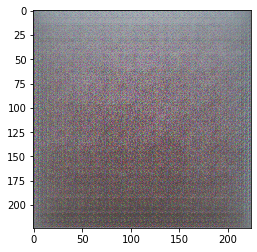

In [56]:
%matplotlib inline
def show(img):
    npimg = img[0].numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def show_sample():
    model.eval()
    with torch.no_grad():
        z = model.sample_latent(2).cuda(args.gpu)
        im_tensor = model.decoder(model.G(z))
        im_tensor = unnormalize(im_tensor)
        show(im_tensor.cpu())

show_sample()